In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

### Question Three

**2.3. Consider the challenge of classifying the likelihood of survival using the Titanic dataset. Construct a decision tree and display the structure of this tree using a graphic**

In [21]:
titanic_data = pd.read_csv('titanic3.csv')[["age", "sex", "pclass", "survived"]]
titanic_data.head()

,age,sex,pclass,survived
0,29.00,female,1,1
1,0.92,male,1,1
2,2.00,female,1,0
3,30.00,male,1,0
4,25.00,female,1,0


Prepare the data

In [22]:
# heck for NaN values
titanic_data.isna().sum()

age         263
sex           0
pclass        0
survived      0
dtype: int64

In [23]:
# Calculate the mean age
mean_age = titanic_data["age"].mean()

# Replace all the NaN values with the mean age
titanic_data["age"] = titanic_data["age"].fillna(mean_age)

#Check for NaN values
titanic_data.isna().sum()

age         0
sex         0
pclass      0
survived    0
dtype: int64

In [24]:
# Convert the gender column to float values
titanic_data["sex binary"] = titanic_data.sex.map({"female":0, "male":1})

# Validate the transformed sex column
titanic_data.head()

,age,sex,pclass,survived,sex binary
0,29.00,female,1,1,0
1,0.92,male,1,1,1
2,2.00,female,1,0,0
3,30.00,male,1,0,1
4,25.00,female,1,0,0


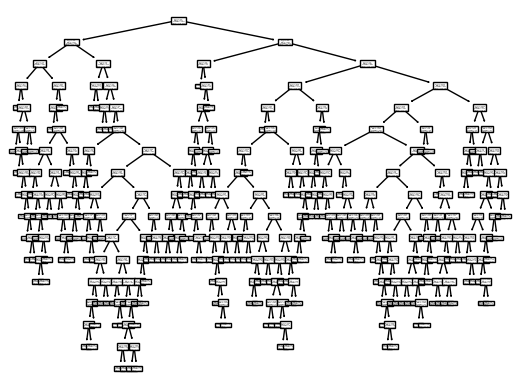

In [119]:
# Set the X and y values
X = titanic_data.drop(columns = ["survived", "sex"])
y = titanic_data[["survived"]]

# Create the model
clf = DecisionTreeClassifier(random_state = 0)

# Fit the titanic data onto the model
titanic_model = clf.fit(X, y)

# Plot the tree from the model created
tree.plot_tree(titanic_model)
plt.show()

**2.4. Evaluate the performance of the tree (before and after pruning) and provide results using cross-validation**

Create folds for the the test and training data and get the accuracy scores

In [102]:
# Create the cross-validation object with five folds
k = 5

kfolds = KFold(n_splits=k, random_state=None, shuffle=False)
scores = cross_val_score(clf, X, y, cv = kfolds, scoring = "accuracy")
print("Accuracy scores:")
scores

Accuracy scores:


array([0.75572519, 0.80152672, 0.76717557, 0.70992366, 0.78927203])

In [103]:
print(f"Average score is {scores.mean()}")
print(f"Standard deviation is {scores.std()}")

Average score is 0.7647246351379018
Standard deviation is 0.031771406682385074


Create the confusion matrix

<Axes: >

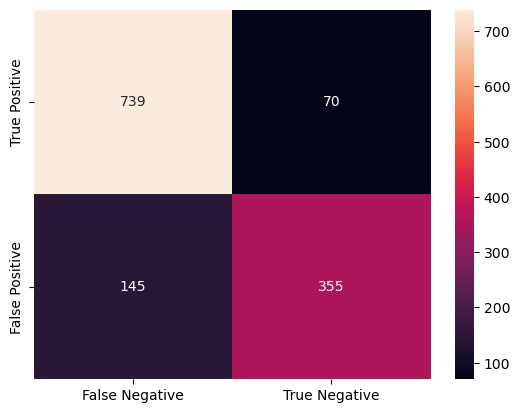

In [111]:
# Run a prediction using the initial model
y_pred_init = titanic_model.predict(X)

# Create the confusion matrix
confusion_matrix_init = metrics.confusion_matrix(y, y_pred_init)

sns.heatmap(confusion_matrix_init,
            annot=True,
            fmt='g',
            xticklabels = ['False Negative', 'True Negative'],
            yticklabels = ['True Positive', 'False Positive'])

Get the misclassification scores

In [117]:
# Get the incorrect predictions
fp_init = confusion_matrix_init[0][1]
fn_init = confusion_matrix_init[1][0]

misclassification_score_init = (fp_init + fn_init) / len(y_pred_init)
print(f"Misclassification score is {misclassification_score_init}")

0.16424751718869365

Prune the tree, by using the max_depth, min_sample_split and min_samples_leaf as hyperparameters

In [118]:
# Define the paramters for the pruning
params = {'max_depth' : [2,4,6,8,10,12],
         'min_samples_split' : [2,3,4],
         'min_samples_leaf' : [1,2]}

gcv = GridSearchCV(estimator=clf, param_grid=params)
gcv.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

In [123]:
pruned_titanic_clf = gcv.best_estimator_

pruned_scores = cross_val_score(pruned_titanic_clf, X, y, cv = kfolds)
print("Pruned Scores: ")
pruned_scores

Pruned Scores: 


array([0.80534351, 0.84732824, 0.76717557, 0.70610687, 0.72413793])

In [125]:
print(f"Average score is {pruned_scores.mean()}")
print(f"Standard deviation is {pruned_scores.std()}")

Average score is 0.770018425901553
Standard deviation is 0.05181208017253168


<Axes: >

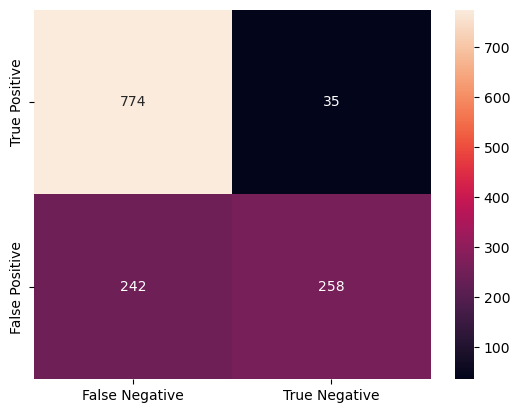

In [127]:
# Run a prediction using the new model
y_pred_pruned = pruned_titanic_clf.predict(X)

# Create the confusion matrix
confusion_maztrix_pruned = metrics.confusion_matrix(y, y_pred_pruned)

sns.heatmap(confusion_matrix_pruned,
            annot=True,
            fmt='g',
            xticklabels = ['False Negative', 'True Negative'],
            yticklabels = ['True Positive', 'False Positive'])

Get the updated misclassifications score

In [128]:
# Get the incorrect predictions
fp_pruned = confusion_matrix_pruned[0][1]
fn_pruned = confusion_matrix_pruned[1][0]

misclassification_score_pruned = (fp_pruned + fn_pruned) / len(y_pred_init)
print(f"Misclassification score is {misclassification_score_pruned}")

Misclassification score is 0.21161191749427044


**2.5. Compare the final tree with logistic regression and comment on the advantages and disadvantages of both. Which model is best for competing in the Kaggle competition? (5)**

Create the logistic error model and generate its confusion matrix

Optimization terminated successfully.
         Current function value: 0.469029
         Iterations 6


<Axes: >

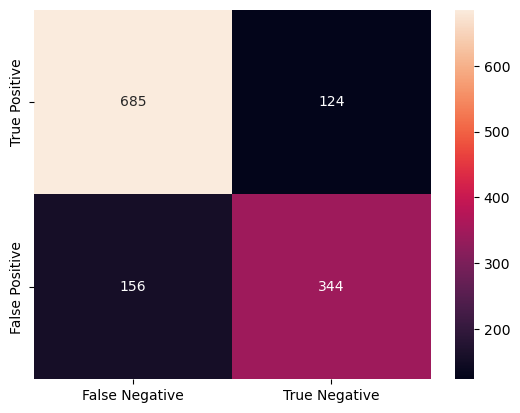

In [132]:
titanic_logit_model = sm.Logit(y, sm.add_constant(X)).fit()

# Get the predicted survival rate from the model
y_pred_logit = round(titanic_logit_model.predict(sm.add_constant(X)))

# Get the confusion matrix
confusion_matrix_logit = metrics.confusion_matrix(y, y_pred_logit)
sns.heatmap(confusion_matrix_logit,
            annot=True,
            fmt='g',
            xticklabels = ['False Negative', 'True Negative'],
            yticklabels = ['True Positive', 'False Positive'])

In [133]:
# Get the incorrect predictions
fp_logit = confusion_matrix_logit[0][1]
fn_logit = confusion_matrix_logit[1][0]

misclassification_score_logit = (fp_logit + fn_logit) / len(y)
print(f"Misclassification score is {misclassification_score_logit}")

Misclassification score is 0.21390374331550802
